## Mapping US household income.

In this demo we will explore, how Lets-Plot Geocoding API and spatial plots are used to create choropleth maps without a use of any additional shapefiles or GeoJSON files.

#### Data

The dataset contains household `mean` income as well as name of City, County and State.

Note that not all US counties are present. This dataset is incomplete but this doesn't really matter for the purpose of this demo.


#### Tasks completed in this notebook:
 - Load and clean the data.
 - Use state geocoder to fetch US states boundaries.
 - Use 1-key form of the `map_join` parameter to create a choropleth map of US states.
 - Use county geocoder to fetch US counties boundaries.
 - Use more 2-key form of the `map_join` parameter to create a choropleth map of US counties.
 - Add the `geom_livemap` layer to display the choropleth on an interactive map.
 
 
To learn more about geocoding in Lets-Plot see: [Geocoding API](https://jetbrains.github.io/lets-plot-docs/pages/features/geocoding.html). 

The geodata is provided by © OpenStreetMap contributors and is made available here under the Open Database License (ODbL).



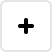
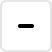
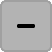
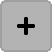
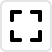
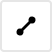
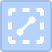

In [1]:
import pandas as pd

from lets_plot import *
from lets_plot.geo_data import *

LetsPlot.setup_html()

In [2]:
import lets_plot
lets_plot.__version__

'2.0.5.dev1'

### Data

In order to keep plots simple we will remove the states of Alaska, Hawaii and Puerto Rico from our dataset.

These 3 states are located far away from the rest [48 contiguous states](https://en.wikipedia.org/wiki/Contiguous_United_States) (aka CONUS) and need to be shown on separate plots. 

In [3]:
income_dat = pd.read_csv('../data/US_household_income_2017.csv', encoding='latin-1')
income_dat.head(3)

id  State_Code State_Name State_ab          County        City  \
0  1011000           1    Alabama       AL   Mobile County   Chickasaw   
1  1011010           1    Alabama       AL  Barbour County  Louisville   
2  1011020           1    Alabama       AL   Shelby County  Columbiana   

             Place  Type Primary  Zip_Code Area_Code     ALand  AWater  \
0   Chickasaw city  City   place     36611       251  10894952  909156   
1        Clio city  City   place     36048       334  26070325   23254   
2  Columbiana city  City   place     35051       205  44835274  261034   

         Lat        Lon   Mean  Median  Stdev        sum_w  
0  30.771450 -88.079697  38773   30506  33101  1638.260513  
1  31.708516 -85.611039  37725   19528  43789   258.017685  
2  33.191452 -86.615618  54606   31930  57348   926.031000

In [4]:
income_dat = income_dat[~income_dat["State_Name"].isin(["Alaska", "Hawaii", "Puerto Rico"])]

In [5]:
income_dat = income_dat[income_dat["Mean"] > 0]
mean_US = income_dat["Mean"].describe()["mean"]
mean_US

67719.94988293362

### Map of the US states.


In [6]:
# Create geocoder for the 48 contiguous states.
state_gcoder = geocode_states("US-48")
state_gcoder.get_geocodes().head(3)

id          state     found name
0  63512          Maine          Maine
1  67213  New Hampshire  New Hampshire
2  60759        Vermont        Vermont

#### Simple blank map.

In [7]:
ggplot() + geom_map(map=state_gcoder)

### Choropleth map - states.

In [8]:
# Compute mean income by the US state.
mean_income_state = income_dat.groupby("State_Name", as_index=False)["Mean"].mean()
mean_income_state.head(3)

State_Name          Mean
0    Alabama  54023.752874
1    Arizona  63400.114943
2   Arkansas  52213.932153

In [9]:
# Define some setting to use on plots later on:
#
# - A gradient color palette. We will borrow color codes from the Brewer's 'PiYG' palette:
#   https://colorbrewer2.org/#type=diverging&scheme=PiYG&n=11
#   We will be using the US mean income as a `midpoint` for the color scale.
map_fill_colors = scale_fill_gradient2(low="#8e0152",mid="#f7f7f7",high="#276419", midpoint=mean_US)

# - Remove axis.
# - Define plot coordinate system and size.
map_settings = (theme(axis_line="blank", axis_text="blank", axis_title="blank", axis_ticks="blank") + 
                map_fill_colors + 
                coord_map() +
                ggsize(900, 400))


In [10]:
# Use `geom_polygon` to create choropleth.
# - pass state geocoder to the `map` parameter.
# - specify the "State_Name" variable (from the dataset) as a single key in the `map_join` parameter.
(ggplot(mean_income_state) + 
 geom_polygon(aes(fill="Mean"), map=state_gcoder, map_join="State_Name", color="white") + 
 map_settings)

#### Adjusting geocoder resolution.

Plot of this size looks too pixelated with the resolution used by default.

To create a better looking choropleth use the `inc_res()` function.

We will also configure a better looking tooltips.

In [11]:
tooltip_state=(layer_tooltips()
          .format('Mean', '.2s')
          .line('@State_Name')
          .line('Mean income|$@Mean'))

(ggplot(mean_income_state) + 
 geom_polygon(aes(fill="Mean"), 
              map=state_gcoder.inc_res(), 
              map_join="State_Name", 
              tooltips=tooltip_state,
              color="white") + 
 map_settings)

### Choropleth map - counties.

In [12]:
# Compute mean income by the US county.
# Note: the resulting dataframe two key variables: "County" and "State_Name".
#       Later we will use these two variables to 'join' this dataframe with counties geocoder data.
mean_income_county = income_dat.groupby(["State_Name","County"], as_index=False)["Mean"].mean()
mean_income_county.head(3)

State_Name          County          Mean
0    Alabama  Autauga County  54086.006522
1    Alabama  Barbour County  37725.000000
2    Alabama   Blount County  55127.000000

In [13]:
# Create geocoder for the US counties.
# Note: in addition to county names we are using here the `states()` function.
#       The `states()` allows us to tell geocoder to use names of states as parent qualifiers for county names.
#       This is necessary because names counties in the US are not unique, i.e. different states can easy have 
#       counties with identical names.
county_gcoder = (geocode_counties(mean_income_county["County"])
    .states(mean_income_county["State_Name"])
    .ignore_all_errors())
county_gcoder.get_geocodes().head(3)

id          county      found name    state
0  1848758  Autauga County  Autauga County  Alabama
1  1850797  Barbour County  Barbour County  Alabama
2  1848761   Blount County   Blount County  Alabama

In [14]:
# Configure tooltip.
tooltip_county=(layer_tooltips()
          .format('Mean', '.2s')
          .line('@County, @State_Name')
          .line('Mean income|$@Mean')
          .color("black"))

In [15]:
# Again, use `geom_polygon` to create choropleth.
# - pass county geocoder to the `map` parameter.
# - specify the "County" and "State_Name" variables as a hieratchical key in the `map_join` parameter.
#   Note: the order of keys in hierarchical key is important.
#         Lets-Plot expects the same order as it is in a US street address, i.e.: city, state, country. 
(ggplot(mean_income_county) + 
 geom_polygon(aes(fill="Mean"), 
              map=county_gcoder, 
              map_join=[["County", "State_Name"]], 
              tooltips=tooltip_county, 
              color="white") + 
 map_settings)

### Interactive map.

Finally, let's add the `geom_livemap()` layer to create an interactive map which you can zoom in and out, and pan.

Note: nbviewer won't load base-map tiles due to its CSP.

In [16]:
(ggplot(mean_income_county) + 
 geom_livemap() +
 geom_polygon(aes(fill="Mean"), 
              map=county_gcoder, 
              map_join=[["County", "State_Name"]], 
              tooltips=tooltip_county, color="white") + 
 map_settings)